# 特征列
### 1.是啥
#### 可以看成原始数据与Estimator之间的转换器？
### 2.为啥
#### 因为原始数据Estimator没法用呗
### 下面来看看特征列对于原始数据做了哪些操作

### 首先需要明确的一点是：很多真实数据都不是数值的
例如：你的名字啦，你的电话啦，你的地址啦
### 但是捏，对于神经网络，可以直接操作的数据类型 ----- 那一定是数字的
所以，像<a>小白样例</a>中，我们设计的神经网络的直接输出并不是鸢尾花的名字，而是我们手动设置的类别，0 ---- 短鸢尾，1 ----中鸢尾，2 ---- 长鸢尾
### 神经网络的输出是数值，输入也一样
说到这个忽然想起 <a>One_Hot</a> 类型，会将0，1，2，3转换成 0000，0100，0010，0001

官网上有一张颇直观的图，特征列是中间那个
<img src = "https://www.tensorflow.org/images/feature_columns/inputs_to_model_bridge.jpg?hl=zh-cn" >

### 介绍一下tf.feature_column?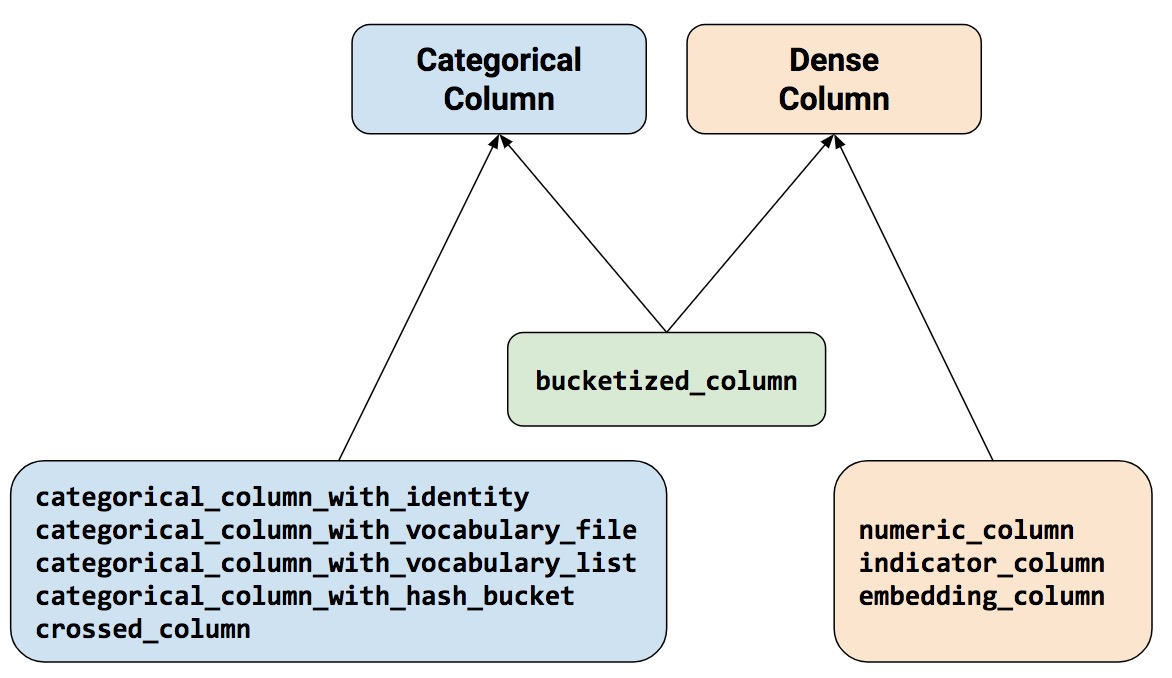

我们一共可以定义九种类型的Feature column

### 先来看第一种 数值型特征列(Nutric column)

In [2]:
import tensorflow as tf

In [3]:
numeric_feature_column = tf.feature_column.numeric_column(key="SepalLength")

In [4]:
print(numeric_feature_column)

_NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


当我们并不添加任何参数时，默认的数值类型是tf.float32
<BR>
当然，你可能并不想用这种类型，所以 👇

In [5]:
numeric_feature_column = tf.feature_column.numeric_column(key="SepalLength",
                                                          dtype=tf.float64)

哦写到这里 突然想到 有时可能不确定某个方法的参数有哪些 这是在代码单元 该方法后打一个？（注意是英文版的问号）就好啦，像这样 👇

In [7]:
tf.feature_column.numeric_column?

其他参数设置同理，就不一一介绍啦

### 第二种 翻译成桶列(Bucketized column)好啦
#### 所谓桶的意思，就是 例如 觉得70-79是一桶人，80-95是一桶人，96(我)是一桶人，97 - 以后是一桶人 -v-
官网上也有给相应的图片说明
<img src = "https://www.tensorflow.org/images/feature_columns/bucketized_column.jpg?hl=zh-cn">
<BR>那相应的，表示这种特征的话...
<br> 1960之前的 ---->[1,0,0,0]
<br> 1960-1979 ---->[0,1,0,0]
<br> 1980-1999 ---->[0,0,1,0]
<br> 2000以后的 ---->[0,0,0,1]
<BR>代码上的实现如下 👇

In [8]:
# 先定义一个数值列
numeric_feature_column = tf.feature_column.numeric_column("Year")

# 再定义“桶” =W=
bucketized_feature_column = tf.feature_column.bucketized_column(
    source_column = numeric_feature_column,
    boundaries = [1960, 1980, 2000])

In [9]:
print(bucketized_feature_column)

_BucketizedColumn(source_column=_NumericColumn(key='Year', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1960, 1980, 2000))


### 第三种 翻译成定值列(Categorical identity column)好啦 -v-
其实是特殊的桶列，但是传统的桶，一般装一堆数值，例如1970-1979，但是定值列，每个桶只装一个值
<BR>再次使用官网图片
<img src = "https://www.tensorflow.org/images/feature_columns/categorical_column_with_identity.jpg?hl=zh-cn">

In [11]:
# 创建一个如上图所示的特征列
identity_feature_column = tf.feature_column.categorical_column_with_identity(
    key='my_feature_b',
    num_buckets=4) # Values [0, 4)

# 此外一些提示
# input_fn()必须返回包含 ‘my_feature_b’作为键值的字典
# 此外部署给 "my_feature_b"的值必须在 0 到 4 之间
def input_fn():
    ...
    return ({ 'my_feature_a':[7, 9, 5, 2], 'my_feature_b':[3, 1, 2, 2] },
            [Label_values])

In [12]:
print(identity_feature_column)

_IdentityCategoricalColumn(key='my_feature_b', num_buckets=4, default_value=None)


### 第四种 翻译成定词列(Categorical vocabulary column)好啦 -v
就是之前 不都是数值嘛 现在改成单词 将单词映射成相应的vector
<BR> 就是下面这种 👇
<img src= "https://www.tensorflow.org/images/feature_columns/categorical_column_with_vocabulary.jpg?hl=zh-cn">

关于穿件这种类型的特征列，TensorFlow提供两种实现方法
*tf.feature_column.categorical_column_with_vocabulary_list
*tf.feature_column.categorical_column_with_vocabulary_file

In [15]:
# 第一种
vocabulary_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(
        key="a feature returned by input_fn()",
        vocabulary_list=["kitchenware", "electronics", "sports"])

In [16]:
print(vocabulary_feature_column)

_VocabularyListCategoricalColumn(key='a feature returned by input_fn()', vocabulary_list=('kitchenware', 'electronics', 'sports'), dtype=tf.string, default_value=-1, num_oov_buckets=0)


但是比较麻烦的一点是vocabulary_list参数，需要输入list，当你创建一万个词条时，手打显然不现实
<BR> 另一个方法还算友好的解决了这个问题

In [18]:
# 第二种
vocabulary_feature_column = tf.feature_column.categorical_column_with_vocabulary_file(
        key="a feature returned by input_fn()",
        vocabulary_file="product_class.txt", #是个txt哦 qwq
        vocabulary_size=3)

检验概括就是传入一个词条txt文件，但是该文件中，每个词条应占一行

### 接下来是第五种 叫哈希列(Hashed Column) 0v0
算是以上定词列的一种扩展吧，以上我们都是讨论小规模的词汇集或者数据集，但假如，有100万个词条，将这些词条都存储下来 对于计算机存储空间而言不太现实
<BR>此时，你应该考虑，我的神经网络可以承载的输入是多少
<BR>哈系列提供了这种方法，自行定义桶的数量，通过取模运算将数据集分为输入所需的几类
* feature_id = hash(raw_feature) % hash_buckets_size//用来解释上面的话

<BR>创建哈希列的代码如下 👇

In [25]:
hashed_feature_column = tf.feature_column.categorical_column_with_hash_bucket(
        key = "some_feature",
        hash_bucket_size = 100) # 输入的类别数量

这种简单粗暴的方法，很容易有个疑问：毫无关联的两个词汇被分为一类输入也没问题吗？（同一类也就意味着 对于神经网络而言，它们是相关的）
<BR> 但神奇的是，哈希在实际应用中效果非常好，是不是很神奇哈-v-

### 接下来是第六种列 ----- 组合列(Crossed column)
该特征列的设计是为了 表达组合特征(<a href = "https://developers.google.com/machine-learning/glossary/?hl=zh-cn#feature_cross">Feature Crossed</a>),是一种将多个独立特征进行组合而形成的合称特征
<br> 
#### 举一个更为具体的例子
假如我们想预测某地发生地震的可能性，那么这个地点的地理位置就是必不可少的信息，而地理位置，至少由经度，纬度两种特征组合，来形成“位置”特征
<br>官网上有给的样例代码 👇 （不过不能运行啦-w-

In [ ]:
def make_dataset(latitude, longitude, labels):
    assert latitude.shape == longitude.shape == labels.shape

    features = {'latitude': latitude.flatten(),
                'longitude': longitude.flatten()}
    labels=labels.flatten()

    return tf.data.Dataset.from_tensor_slices((features, labels))

# Bucketize the latitude and longitude usig the `edges`
latitude_bucket_fc = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'),
    list(atlanta.latitude.edges))

longitude_bucket_fc = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    list(atlanta.longitude.edges))

# Cross the bucketized columns, using 5000 hash bins.
crossed_lat_lon_fc = tf.feature_column.crossed_column(
    [latitude_bucket_fc, longitude_bucket_fc], 5000)

fc = [
    latitude_bucket_fc,
    longitude_bucket_fc,
    crossed_lat_lon_fc]

# Build and train the Estimator.
est = tf.estimator.LinearRegressor(fc, ...)

In [27]:
tf.feature_column.crossed_column?

* 但有一点反直觉的是，就算建立了合称特征列，仍然需要使用原始特征列作为训练模型的输入，独立的经度列和纬度列可以帮助模型区分哈希值相同的独立特征

### 第七种 指示符列(Indicator columns)
指示符列只能将Categorical Columns作为输入，而不是具体特征
<br>（大概已经忘了Categorical column有哪些，所以在下面放了图片
<img src = "https://www.tensorflow.org/images/feature_columns/some_constructors.jpg?hl=zh-cn">

然后说来你可能不信，它和之前的定值列几乎做一种事，就是，👇
<img src = "https://www.tensorflow.org/images/feature_columns/categorical_column_with_identity.jpg?hl=zh-cn">


代码的创建过程也十分简单，但注意原始特征值不能直接作为输入哦
<br>提前说明：下面这行代码不能运行

In [ ]:
categorical_column = ... # 首先。。。

# 然后在传入指示符特征列
indicator_column = tf.feature_column.indicator_column(categorical_column)

呐，现在呢，假设，你所需要判定的类别突然增大了，也就是之前只有一千个类别，现在有一万个类别，这个时候再用当前方法，就很不灵活了，
## 所以
### 嵌入列(Embedding Column)就是用来解决这个问题的
其实就是随意版的指示符列啦，指示符列每个verctor只有0和1，但是嵌入列的值是随意啦
<br>有图为证 👇
<img src = "https://www.tensorflow.org/images/feature_columns/embedding_vs_indicator.jpg?hl=zh-cn">


#### 关于嵌入列的维度，例如👆图中，Embedding column为何是3维？
<br>维度，一般可以用以下公式计算:
* embedding_dimensions =  number_of_categories**0.25

<br>但以上公式只是提供一个通用法则，你也可以自行指定嵌入列的维度
<br>伪代码如下图所示 👇

In [ ]:
categorical_column = ... # Create any categorical column

# Represent the categorical column as an embedding column.
# This means creating a one-hot vector with one element for each category.
embedding_column = tf.feature_column.embedding_column(
    categorical_column=categorical_column,
    dimension=dimension_of_embedding_vector)

* Embedding是机器学习中的重要内容，更多细节查看另一个<a href = "" >Embedding Tutorial </a>

#### 最后一点需要说明的是，不是所有Estimator都支持所有类型的特征列
#### 1. LinearClaassifier和LinearRegressor: 
支持所有类型特征列
#### 2. DNNClassifier和DNNRegressor：
并不支持Categorical类型的特征列，如果需要使用这些类型的特征列，需要传入Indicator column或者Embedding Column后再使用
#### 3. DNNLinearCombinedClassifier和DNNLinearCombinedRegressor：
linear_feature_columns参数支持各种类型的特征列，dnn_feature_columns不支持categorical类型的特征列